In [128]:
%matplotlib inline
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import scipy.stats as st
import seaborn as sns
import plotly.graph_objects as go
from typing import Dict, Any, Optional
import plotly.express as px
import ast

_FIG_SIZE=(6,5)
_BENCHMARK_COMPARISONS ={
    "imagenet": dict(
        static=dict(s80=(72.1, 0.04), s90=(67.7,0.12)),
        SET=dict(s80=(72.9, 0.39), s90=(69.6, 0.23)),
        SNFS=dict(s80=(75.2, 0.11), s90=(73.0, 0.04)),
        GMP=dict(s80=(75.6, 0), s90=(73.9,0)),
        LTR=dict(s80=(75.6,0), s90=(-100, -100)),
        RigL_ITOP=dict(s80=(75.84, 0.05), s90=(73.82,0.08)),
        RigL_ITOPx2=dict(s80=(76.91, 0.07), s90=(75.50,0.09)),
    )
}
_MIN_SAL_PER_LAYER=[1, 2, 3, 1, 1, 7, 3, 1, 7, 3, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1, 7, 2, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1, 7, 2, 1, 7, 2, 1, 7, 2, 1, 4, 2, 1, 2, 7, 2, 1, 7, 2, 1]

_RESNET18_BENCHMARK=0.9545
_WIDE_RESNET_BENCHMARK=0.95
_IMAGENET_BENCHMARK=0.7674
_BEST_MIN_SAL_THRES=0.3
# _PLOT_FUNCT = "plot"
_PLOT_FUNCT = "scatter"
_GROUPBY_VARS = [
    "rigl.const_fan_in",
    "rigl.dense_allocation",
    "rigl.dynamic_ablation",
    "rigl.min_salient_weights_per_neuron",
]
_SUMMARY_COLS = [
    "name",
    "sweep_id",
    "tags",
    "best_accuracy",
    "rigl.const_fan_in",
    "rigl.dense_allocation",
    "rigl.min_salient_weights_per_neuron",
    "epoch"
]
_SRIGL_PARAMS = {
    'dense_allocation': {
        0: 0.01,
        1: 0.05,
        2: 0.0625,
        3: 0.1,
        4: 0.2,
        5: 0.25,
       },
    'parameters': {0: 274072,
    1: 1289784,
    2: 1611784,
    3: 2571656,
    4: 5113920,
    5: 6391944,}
    ,
    'dense_params': {0: 25557032,
    1: 25557032,
    2: 25557032,
    3: 25557032,
    4: 25557032,
    5: 25557032,
    },
'flops': {0: 210148061.279257,
  1: 1006217258.8635536,
  2: 1254965374.5630252,
  3: 1988961489.7515674,
  4: 3395291627.141983,
  5: 3903734360.67288},
    }



_MEAN_MARKER=dict(s=80, facecolors='none', marker='o', alpha=1.0, linewidths=2)
_SAMPLE_MARKER=dict(s=7.5, facecolors='full', marker='.', alpha=0.2)

_SR_STE_PARAMS = {
    'dense_allocation': {
        0: 0.0625,
        1: 0.25,
    },
    'parameters': {
        0: 3.52*1e6,
        1: 7.93*1e6
    },
    'dense_params': {
        0: 25557032,
        1: 25557032,
    },
    "mean": {
        0: 71.5,
        1: 76.2,
    },
    "upper_bound": {
        0: 71.5,
        1: 76.2,
    },
    "lower_bound": {
        0: 71.5,
        1: 76.2,
    },
    "macs": {
        0: 0.44e9,
        1: 1.17e9
    },
    "flops": {
        0: 0.44e9*2,
        1: 1.17e9*2, 
    }
}

_SRIGL_PARAMS = pd.DataFrame(_SRIGL_PARAMS)
_SR_STE_PARAMS = pd.DataFrame(_SR_STE_PARAMS)
plt.style.use("../plt_plot_style.mplstyle")

# flops_df = pd.read_csv("../flops.csv")

In [129]:
# fig,ax = plt.subplot(figsize=_FIG_SIZE)
# ax.plot()

In [130]:
_SRIGL_PARAMS

,dense_allocation,parameters,dense_params,flops
0,0.0100,274072,25557032,2.101481e+08
1,0.0500,1289784,25557032,1.006217e+09
2,0.0625,1611784,25557032,1.254965e+09
3,0.1000,2571656,25557032,1.988961e+09
4,0.2000,5113920,25557032,3.395292e+09
5,0.2500,6391944,25557032,3.903734e+09


In [131]:
2.456845e+10/1e9

24.56845

In [132]:
_SRIGL_PARAMS = pd.read_csv("../flops_and_params.csv")
_SRIGL_PARAMS["dense_allocation"] = _SRIGL_PARAMS["rigl.dense_allocation"]

In [133]:
_SRIGL_PARAMS

,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,dense_allocation
0,0,NaN,8.189482e+09,resnet50,25530472.0,1.000000,3.147628e+18,1.000000,NaN
1,1,0.0100,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,0.0100
2,2,0.0500,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,0.0500
3,3,0.0625,1.254965e+09,resnet50,2418458.0,0.153241,4.943262e+17,0.157047,0.0625
4,4,0.1000,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,0.1000
5,5,0.2000,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,0.2000
6,6,0.2500,3.903734e+09,resnet50,7181400.0,0.476677,1.515741e+18,0.481550,0.2500


In [134]:
_BENCHMARK_COMPARISONS
methods = [k for k in _BENCHMARK_COMPARISONS["imagenet"].keys()]
sparsity = [80 for _ in list(range(len(methods)))]
sparsity.extend([90 for _ in list(range(len(methods)))])

s80_means = [_BENCHMARK_COMPARISONS["imagenet"][m]["s80"][0] for m in methods]
x80_upper_bound = [acc+_BENCHMARK_COMPARISONS["imagenet"][m]["s80"][1] for m,acc in list(zip(methods, s80_means))]
x80_lower_bound = [acc-_BENCHMARK_COMPARISONS["imagenet"][m]["s80"][1] for m,acc in list(zip(methods, s80_means))]

s90_means = [_BENCHMARK_COMPARISONS["imagenet"][m]["s90"][0] for m in methods]
x90_upper_bound = [acc+_BENCHMARK_COMPARISONS["imagenet"][m]["s90"][1] for m,acc in list(zip(methods, s90_means))]
x90_lower_bound = [acc-_BENCHMARK_COMPARISONS["imagenet"][m]["s90"][1] for m,acc in list(zip(methods, s90_means))]

mean=[]
mean.extend(s80_means)
mean.extend(s90_means)
upper_bound=[]
upper_bound.extend(x80_upper_bound)
upper_bound.extend(x90_upper_bound)
lower_bound=[]
lower_bound.extend(x80_lower_bound)
lower_bound.extend(x90_lower_bound)
methods.extend(methods)

imagenet_sparse_benchmarks = dict(
    method = methods,
    sparsity = sparsity,
    mean=mean,
    upper_bound=upper_bound,
    lower_bound=lower_bound
)
imagenet_sparse_benchmarks = pd.DataFrame(imagenet_sparse_benchmarks)
imagenet_sparse_benchmarks = imagenet_sparse_benchmarks.drop(imagenet_sparse_benchmarks.loc[(imagenet_sparse_benchmarks["method"]=="LTR") & (imagenet_sparse_benchmarks["sparsity"]==90)].index.item())
imagenet_sparse_benchmarks

,method,sparsity,mean,upper_bound,lower_bound
0,static,80,72.10,72.14,72.06
1,SET,80,72.90,73.29,72.51
2,SNFS,80,75.20,75.31,75.09
3,GMP,80,75.60,75.60,75.60
4,LTR,80,75.60,75.60,75.60
5,RigL_ITOP,80,75.84,75.89,75.79
6,RigL_ITOPx2,80,76.91,76.98,76.84
7,static,90,67.70,67.82,67.58
8,SET,90,69.60,69.83,69.37
9,SNFS,90,73.00,73.04,72.96


In [135]:
structured_sparse_benchmarks= pd.DataFrame(
    dict(
        method=["SR-STE", "SR-STE",],
        sparsity=[75, 93.75],
        mean=[76.2,71.5],
        upper_bound=[76.2,71.5],
        lower_bound=[76.2,71.5],
    )
)
structured_sparse_benchmarks

,method,sparsity,mean,upper_bound,lower_bound
0,SR-STE,75.00,76.2,76.2,76.2
1,SR-STE,93.75,71.5,71.5,71.5


In [136]:
_BENCHMARK_COMPARISONS

{'imagenet': {'static': {'s80': (72.1, 0.04), 's90': (67.7, 0.12)},
  'SET': {'s80': (72.9, 0.39), 's90': (69.6, 0.23)},
  'SNFS': {'s80': (75.2, 0.11), 's90': (73.0, 0.04)},
  'GMP': {'s80': (75.6, 0), 's90': (73.9, 0)},
  'LTR': {'s80': (75.6, 0), 's90': (-100, -100)},
  'RigL_ITOP': {'s80': (75.84, 0.05), 's90': (73.82, 0.08)},
  'RigL_ITOPx2': {'s80': (76.91, 0.07), 's90': (75.5, 0.09)}}}

In [137]:
def fill_na_cols(df):
    df["rigl.min_salient_weights_per_neuron"] = df["rigl.min_salient_weights_per_neuron"].fillna(0)
    df["rigl.dynamic_ablation"] = df["rigl.dynamic_ablation"].fillna(False)
    df.loc[df["model.name"].isna(), "model.name"] = df["model"]
    df.loc[df["model"].isna(), "model"] = df["model.name"]
    return df
df = pd.read_csv("../processed_results.csv", index_col="id")
df = fill_na_cols(df)
df.head()

/tmp/ipykernel_64932/527118440.py:7: DtypeWarning: Columns (14,15,16,20,21,22,27,28,29,31,33,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128,129,130,131,132,133,134,135,136,137,138,139,140,141,142,143,144,145,146,147,148,149,150,151,152,153,154,155,156,157,158,159,160,161,162,163,164,165,166,167,168,169,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,191,192,193,194,195,196,197,198,199,200,201,202,203,204,205,206,207,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257,258,259,260,261,262,263,264,265,266,267,268,269,270,271,272,273,274,275,276,277,278,27

,ITOP Rate,Learning Rate,Training Loss,Unnamed: 0,_PRUNING_RATE,_TOTAL_ACTIVE_NEURONS,_TOTAL_PERCENTAGE_ACTIVE_NEURONS,_runtime,_step,_timestamp,...,z-module.layer4.2.conv3-Max-Grad-Per-Filter.values,z-module.layer4.2.conv3-Max-Inactive_Grad,z-module.layer4.2.conv3-Max-Inactive_Weight,z-module.layer4.2.conv3-Max-Weight-Per-Filter._type,z-module.layer4.2.conv3-Max-Weight-Per-Filter.bins,z-module.layer4.2.conv3-Max-Weight-Per-Filter.values,z-module.layer4.2.conv3-Weight-Dist._type,z-module.layer4.2.conv3-Weight-Dist.bins,z-module.layer4.2.conv3-Weight-Dist.values,z-module.layer4.2.conv3_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
2aoeiijo,0.860375,0.0001,2.169331,0,0.000005,20455.0,74.219884,197857.0,2048001.0,1.675903e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3g41bcjo,0.754617,0.0001,2.135979,1,0.000005,17875.0,64.858491,200608.0,2048001.0,1.675906e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1v4uuvf1,NaN,NaN,NaN,2,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1oyi5wrj,0.230380,0.0001,2.880667,3,0.000005,11507.0,41.752540,200545.0,2048001.0,1.675906e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
cfv9o2l1,0.156520,0.0002,3.375155,4,0.000013,21909.0,79.495646,130337.0,256001.0,1.675530e+09,...,"[1011, 43, 35, 48, 32, 37, 30, 45, 40, 29, 39,...",0.000002,0.0,histogram,"[0, 0.008204862475395203, 0.016409724950790405...","[973, 15, 15, 10, 18, 19, 22, 18, 40, 38, 53, ...",histogram,"[-0.46793174743652344, -0.45241546630859375, -...","[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 3, 3, ...",1077.0


In [138]:
df_test = pd.read_csv("../processed_results_03.csv", index_col="id")

In [139]:
for col in df_test.columns:
    if col not in df.columns:
        print(col)

rigl.initialize_grown_weights


In [140]:
# # import subprocess
# # import glob
# # import datetime``
# # import re


# # for model in ["resnet18", "wide_resnet22"]:
# #     for _DENSE_ALLOC in [0.01, 0.05, 0.1]:
# #         for _MIN_SAL in [0.30, 0.40, 0.5]:
# for model in ["resnet18",]:
#     for _DENSE_ALLOC in [0.01,]:
#         for _MIN_SAL in [0.5]:
#             df_slice = df.loc[
#                 (df["sweep_id"]=="1fik36lx") & \
#                 (df["tags"].str.contains("sweep_1fik36lx")) & \
#                 (df["model"]==model) & \
#                 (df["rigl.dense_allocation"] == _DENSE_ALLOC)  & \
#                 (df["rigl.min_salient_weights_per_neuron"] == _MIN_SAL)
#             ]
#             print(model, _DENSE_ALLOC, _MIN_SAL)
#             ids = df_slice.index.values
#             print(ids)
#             # g = glob.glob("../artifacts/checkpoints/*")
#             # for i, row in df_slice.iterrows():
#             #     id = row.name
#             #     date_str = datetime.datetime.fromtimestamp(row._timestamp)
#             #     src_dir = f"../artifacts/checkpoints/{date_str.strftime('%Y%m%d')}_{id}"
#             #     # assert src_dir in g
#             #     target_dir = f"../artifacts/checkpoints/for_anna_2/{model}-{(1-_DENSE_ALLOC)*100:.0f}-{_MIN_SAL*100:.0f}"
#             #     if src_dir not in g:
#             #         src_dir = f"../artifacts/checkpoints/{(date_str - datetime.timedelta(days=2)).strftime('%Y%m%d')}_{id}"
#             #         if src_dir not in g:
#             #             src_dir = f"../artifacts/checkpoints/{(date_str - datetime.timedelta(days=1)).strftime('%Y%m%d')}_{id}"
#             #             if src_dir not in g:
#             #                 print(f'Cant find {src_dir}')
#             #     args = f"mkdir -p {target_dir}"
#             #     # print(args)
#             #     subprocess.call(args.split(" "))
#             #     args = f"cp -r {src_dir} {target_dir}"
#             #     # print(args)
#             #     subprocess.call(args.split(" "))

In [141]:
# from itertools import product

# param_sweep = {"rigl.dense_allocation": [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],
#                "rigl.min_salient_weights_per_neuron":[0.5, 0.4, 0.3, 0.2, 0.1, 0.05, 0.01, 0.005],
#                "training.seed":[8746, 6037, 7303, 2078, 42],
#                "model": ["resnet18", "wide_resnet22"], 
#                "sweep_id": ["1fik36lx"]
# }


# def get_missing_params(param_sweep, df):
#     keys = param_sweep.keys()
#     vals = param_sweep.values()
#     missing_params = []
#     for instance in product(*vals):
#         missing_params.append({k: v for k,v in list(zip(keys, instance))})
#     return missing_params
        

# # df.loc[df["sweep_id"]=="1fik36lx"]
# # vars=["rigl.dense_allocation", "rigl.min_salient_weights_per_neuron", "training.seed", "model"]
# # df_slice = df.loc[df["sweep_id"]=="1fik36lx"]
# # df_slice.groupby(vars).count()["best_accuracy"]
    
# missing_params = get_missing_params(param_sweep, df)
# # print([df[k]==v for k,v in missing_params[0].items()])


# def get_df_slice(params, df):
#     missing_params = []
#     for instance in params:
#         df_slice = df.copy()
#         for k,v in instance.items():
#             df_slice = df_slice.loc[df[k]==v]
#         if len(df_slice) == 0:
#             # print(instance)
#             missing_params.append(instance)
#     return missing_params


# df_slice = get_df_slice(missing_params, df)
# df_slice
# # for params in product(dense_alloc.values(), min_sal.values(), seed.values(), model.values()):
# #     print(params)
# #     print(type(params))
    
# # # dense_alloc.values()
# # # for params in product([0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5],["a", "b", "c"]):
# # #     print(params)
# # #     print(type(params))
    
# # dense_alloc

In [142]:
def model_state_filter(df, epoch=250):
    return df.loc[(df["state"]=="finished") & (df["epoch"]==epoch)]

def display_group_by(df, groupby_vars, sort_by = "accuracy"):
    return df.groupby(groupby_vars).mean().sort_values(by=sort_by, ascending=False)[sort_by]

def get_model_name_filter(df, model_name):
    return df.loc[((df['model.name']==model_name) | (df['model']==model_name))] 

def get_sparse_grad_flow(df):
    return df.loc[df["rigl.init_method_str"] == "grad_flow_init"]

def get_sparse_saliency(df):
    return df[~df["name"].str.contains("salients_only")]
    # return df.loc[df["rigl.use_sparse_const_fan_in_for_ablation"]==True]
    

def get_model_results(df, model_name="resnet18", expected_epochs=250):
    model_df = model_state_filter(df, expected_epochs)
    model_df = get_model_name_filter(model_df, model_name)
    model_df = get_sparse_grad_flow(model_df)
    # model_df = get_sparse_saliency(model_df)
    return model_df


# resnet18=get_model_results(df, "resnet18", 250)
# wide_resnet22=get_model_results(df, "wide_resnet22", 250)

cifar_const_fan = df.loc[df['tags'].str.contains("sweep_1fik36lx")]
resnet18_const_fan = cifar_const_fan.loc[(cifar_const_fan["model"]=="resnet18") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == _BEST_MIN_SAL_THRES)]
resnet18_og_rigl = df.loc[(df['sweep_id']=="a2uywunn") & (df["model"]=="resnet18")]
resnet18_no_ablation = df.loc[(df["sweep_id"]=="fn7pgfly") & (df["rigl.min_salient_weights_per_neuron"]==0)& (df["model"]=="resnet18")]  # TODO: Replace with new sweep
resnet18 = pd.concat([resnet18_const_fan, resnet18_og_rigl, resnet18_no_ablation])
resnet_ids=resnet18.index

wide_resnet22_const_fan = cifar_const_fan.loc[(cifar_const_fan["model"]=="wide_resnet22") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == _BEST_MIN_SAL_THRES)]
wide_resnet22_og_rigl = df.loc[(df['sweep_id']=="a2uywunn") & (df["model"]=="wide_resnet22")]
wide_resnet22_no_ablation = df.loc[(df["sweep_id"]=="fn7pgfly") & (df["rigl.min_salient_weights_per_neuron"]==0)& (df["model"]=="wide_resnet22")]  # TODO: Replace with new sweep
wide_resnet22 = pd.concat([wide_resnet22_og_rigl, wide_resnet22_const_fan, wide_resnet22_no_ablation])
wide_res_ids=wide_resnet22.index

imagenet=get_model_results(df, "resnet50", 103)
imagenet_og_rigl = imagenet.loc[imagenet["rigl.const_fan_in"]==False]
imagenet_x5=get_model_results(df, "resnet50", 512)  # TODO: Update with new
imagenet_x2=get_model_results(df, "resnet50", 205)
imagenet_x2=imagenet_x2.loc[imagenet_x2["tags"].str.contains("narval_cluster")]
imagnet_net_const_fan_no_ablation_sweep_id = "snb0sphc"
imagenet_no_ablation = imagenet.loc[imagenet["sweep_id"] == imagnet_net_const_fan_no_ablation_sweep_id] 
imagnet_net_const_fan_x1_with_ablation_tag = "x1-steps"
imagenet_st_sre_comparison_tag = "sr-ste-benchmarks"
imagenet_x1 = df.loc[df["tags"].str.contains(imagnet_net_const_fan_x1_with_ablation_tag)]
imagenet_st_sre_comparison = df.loc[df["tags"].str.contains(imagenet_st_sre_comparison_tag)]
imagenet = pd.concat([imagenet_no_ablation, imagenet_x1, imagenet_x5, imagenet_og_rigl, imagenet_x2, imagenet_st_sre_comparison])

skinny_resnet = df.loc[df['sweep_id'] == "jporfu3v"]
resnet18_99_50 = cifar_const_fan.loc[(cifar_const_fan["model"]=="resnet18") &  (cifar_const_fan["rigl.min_salient_weights_per_neuron"] == 0.5) * (cifar_const_fan["rigl.dense_allocation"]==0.01)]
resnet18_og_rigl_001 = resnet18_og_rigl.loc[resnet18_og_rigl["rigl.dense_allocation"] == 0.01]
skinny_resnet = pd.concat([skinny_resnet, resnet18_99_50, resnet18_og_rigl_001, ])


# imagenet = imagenet.loc[imagenet["sweep_id"].isin(["aw7o7hz7", "snb0sphc"])]

In [143]:
imagenet_x1["rigl.dense_allocation"]

id
1oid9nmo    0.05
14so3lij    0.10
2brxovy4    0.01
4zbwd4nt    0.20
Name: rigl.dense_allocation, dtype: float64

In [144]:
imagenet_x1.index.to_list()

['1oid9nmo', '14so3lij', '2brxovy4', '4zbwd4nt']

In [145]:
resnet18_og_rigl.loc[resnet18_og_rigl["rigl.dense_allocation"] == 0.01]

,ITOP Rate,Learning Rate,Training Loss,Unnamed: 0,_PRUNING_RATE,_TOTAL_ACTIVE_NEURONS,_TOTAL_PERCENTAGE_ACTIVE_NEURONS,_runtime,_step,_timestamp,...,z-module.layer4.2.conv3-Max-Grad-Per-Filter.values,z-module.layer4.2.conv3-Max-Inactive_Grad,z-module.layer4.2.conv3-Max-Inactive_Weight,z-module.layer4.2.conv3-Max-Weight-Per-Filter._type,z-module.layer4.2.conv3-Max-Weight-Per-Filter.bins,z-module.layer4.2.conv3-Max-Weight-Per-Filter.values,z-module.layer4.2.conv3-Weight-Dist._type,z-module.layer4.2.conv3-Weight-Dist.bins,z-module.layer4.2.conv3-Weight-Dist.values,z-module.layer4.2.conv3_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
q1c5ldrm,0.209189,0.0008,0.031376,834,8.651855e-08,2539.0,52.785863,18355.0,97500.0,1.671771e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
gp8uog4a,0.207978,0.0008,0.023401,837,8.651855e-08,2565.0,53.326403,20916.0,97500.0,1.671774e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8euvnykc,0.193083,0.0008,0.050119,839,8.651855e-08,2344.0,48.731809,88159.0,97500.0,1.671858e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
47keahsb,0.192165,0.0008,0.057705,841,8.651855e-08,2352.0,48.898129,18741.0,97500.0,1.671771e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
jn8w8nmg,0.210617,0.0008,0.041604,842,8.651855e-08,2517.0,52.328482,20184.0,97500.0,1.671773e+09,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [146]:
skinny_resnet.loc[(skinny_resnet["rigl.const_fan_in"] == False) & (~skinny_resnet["rigl.dense_allocation"].isna())][_SUMMARY_COLS].sort_values(by="best_accuracy", ascending=False)

,name,sweep_id,tags,best_accuracy,rigl.const_fan_in,rigl.dense_allocation,rigl.min_salient_weights_per_neuron,epoch
id,,,,,,,,
y29qhvrw,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9308,False,0.01,0.5,250.0
q1c5ldrm,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9303,False,0.01,0.0,250.0
shxuffw0,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9302,False,0.01,0.5,250.0
nfhyyil0,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9300,False,0.01,0.5,250.0
mi3b4qs7,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9298,False,0.01,0.5,250.0
gp8uog4a,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9298,False,0.01,0.0,250.0
jq9npp65,skinny_resnet18_cifar10_dense_alloc-0.01_const...,jporfu3v,[],0.9295,False,0.01,0.5,250.0
jn8w8nmg,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9288,False,0.01,0.0,250.0
47keahsb,resnet18_cifar10_dense_alloc-0.01_const_fan_in...,a2uywunn,[],0.9287,False,0.01,0.0,250.0


In [147]:
gdf = resnet18.groupby(_GROUPBY_VARS).count()["best_accuracy"]
print(f"Any run set with more than 5 seeds? {(gdf != 5).any()}.")
resnet_ids=resnet18.index
df.loc[resnet_ids].groupby(["rigl.dense_allocation"])['best_accuracy'].count()  # We expect 15, 5 seeds x 3 experiments (OG, no ablation, ablation)

Any run set with more than 5 seeds? False.


rigl.dense_allocation
0.01    15
0.05    15
0.10    15
0.20    15
0.30    15
0.40    15
0.50    15
Name: best_accuracy, dtype: int64

In [148]:
gdf = wide_resnet22.groupby(_GROUPBY_VARS).count()["best_accuracy"]
print(f"Any run set with more than 5 seeds? {(gdf != 5).any()}.")
wide_res_ids=wide_resnet22.index
df.loc[wide_res_ids].groupby(["rigl.dense_allocation"])['best_accuracy'].count()  # We expect 45, 5 seeds and 3 experiments (OG, no ablation, ablation)

Any run set with more than 5 seeds? False.


rigl.dense_allocation
0.01    15
0.05    15
0.10    15
0.20    15
0.30    15
0.40    15
0.50    15
Name: best_accuracy, dtype: int64

In [149]:
import copy
this_group = copy.deepcopy(_GROUPBY_VARS)
this_group.extend(["epoch"])
gdf = imagenet.groupby(this_group).count()["best_accuracy"]
gdf  # TODO: Remove 0.005 runs once other x5 runs finish

rigl.const_fan_in  rigl.dense_allocation  rigl.dynamic_ablation  rigl.min_salient_weights_per_neuron  epoch
False              0.0100                 True                   0.005                                103.0    1
                   0.0500                 True                   0.005                                103.0    1
                   0.1000                 True                   0.005                                103.0    1
                   0.2000                 True                   0.005                                103.0    1
True               0.0100                 False                  0.000                                103.0    1
                                          True                   0.005                                512.0    1
                                                                 0.300                                103.0    1
                                                                                                     

In [150]:
# resnet18 = model_state_filter(df)
# resnet18 = get_model_name_filter(resnet18, "resnet18")
# sparsities = [0.20,0.30,0.40,0.50]


# new_high_sparse_ids = resnet18.loc[
#     (resnet18["rigl.const_fan_in"]==True) & \
#     (resnet18["rigl.min_salient_weights_per_neuron"] == 0.3) & \
#     (resnet18["rigl.use_sparse_const_fan_in_for_ablation"] == True) & \
#     (resnet18["tags"].str.contains("sweep_1fik36lx"))
# ].index.to_list()


# vanilla_ids = []
# for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
#     vanilla_ids.extend(
#         resnet18.loc[
#             (resnet18["rigl.const_fan_in"]==False) & \
#             (resnet18["rigl.dense_allocation"] == s) & \
#             (resnet18["sweep_id"]=="a2uywunn")
#         ].index.to_list()
#     )

# resnet18_no_ablation_ids=[]
# for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
#     resnet18_no_ablation_ids.extend(
#         resnet18.loc[
#             (resnet18["rigl.const_fan_in"]==True) & \
#             (resnet18["rigl.dense_allocation"] == s) & \
#             (resnet18["sweep_id"]=="4hsfzsa9")  # TODO -> Rerun with sparse init
#         ].index.to_list()
#     )

# print(df.loc[vanilla_ids].groupby("rigl.dense_allocation").count()['accuracy'])
# print(df.loc[new_high_sparse_ids].groupby("rigl.dense_allocation").count()['accuracy'])
# print(df.loc[resnet18_no_ablation_ids].groupby("rigl.dense_allocation").count()['accuracy'])
# # print(df.loc[other_runs].groupby("rigl.dense_allocation").count()['accuracy'])
# resnet_ids = vanilla_ids + new_high_sparse_ids + resnet18_no_ablation_ids
# len(resnet_ids)

In [151]:
# model_name="wide_resnet22"
# model_df = model_state_filter(df)
# model_df = get_model_name_filter(model_df, model_name)
# wide_const_fan_ids = []
# wide_vanilla=[]
# densities = [0.2,0.3,0.4,0.5,0.1,0.05,0.01]
# for d in densities:
#     wide_const_fan_ids.extend(
#         model_df.loc[
#             (model_df["rigl.min_salient_weights_per_neuron"] == 0.005) &\
#             (model_df["rigl.dense_allocation"] == d) & \
#             (model_df["rigl.grad_accumulation_n"]!=8) & \
#             (model_df["tags"].str.contains("sweep_1fik36lx"))
#         ].index.to_list()
#     )
# for d in densities:
#     wide_vanilla.extend(
#         model_df.loc[
#             (model_df["rigl.const_fan_in"]==False) & \
#             (model_df["rigl.dense_allocation"] == d) & \
#             (model_df["rigl.grad_accumulation_n"]!=8) & \
#             (model_df["sweep_id"] == "a2uywunn")
#         ].index.to_list()
#     )

# wideresnet22_no_ablation_ids=[]
# for s in [0.01, 0.05, 0.1, 0.2, 0.3 ,0.4, 0.5]:
#     wideresnet22_no_ablation_ids.extend(
#         model_df.loc[
#             (model_df["rigl.const_fan_in"]==True) & \
#             (model_df["rigl.dense_allocation"] == s) & \
#             (model_df["sweep_id"]=="4hsfzsa9")  # TODO -> Rerun with sparse init
#         ].index.to_list()
#     )
    
# wide_res_ids=wide_vanilla+wide_const_fan_ids+wideresnet22_no_ablation_ids
# len(wide_res_ids)

## PLOTTING

In [152]:
# PLOTTING HELPERS
# _COLORS=['#00a5bb','#f79141','#d81e52',  '#6c77c5', '#499585', '#6cb2c5' , '#c5ba6c', '#56ce93', '#d88fBf', '#ffd505', "#000000"]

_COLORS = sns.color_palette("tab10").as_hex()
from typing import Tuple
def get_confidence_bounds_df(df: pd.DataFrame, alpha=0.95, target_col:str = "best_accuracy", x_col="sparsity"):
    df = df.copy()
    results = {
        x_col:[],
        "mean":[],
        "lower_bound":[],
        "upper_bound":[],
    }
    for sparsity in df[x_col].unique():
        this_df = df.loc[df[x_col] == sparsity]
        results[x_col].append(sparsity)
        results["mean"].append(this_df[target_col].mean())
        lower, upper = st.t.interval(
            alpha=alpha,
            df=len(this_df[target_col])-1,
            loc=this_df[target_col].mean(),
            scale=st.sem(this_df[target_col])
        )
        results["lower_bound"].append(lower)
        results["upper_bound"].append(upper)
    return pd.DataFrame(results)

from typing import List
def series_name_plot_mapper(const_fan_in: bool, dynamic_ablation: bool, epoch_values: List[int], epoch: int) -> Tuple[str]:
    epoch_values = sorted(epoch_values)
    epoch_color_value_inc = {epoch: 2+i for i, epoch in enumerate(epoch_values)}
    if const_fan_in and dynamic_ablation:
        name = "SRigL"
        if len (epoch_values) >1:
            steps_multiplier = round(epoch / epoch_values[0])
            # if steps_multiplier == 1:
            #     color=_COLORS[2]
            # else:
            #     color=_COLORS[epoch_color_value_inc[epoch]]
            if steps_multiplier != 1:
                name = name + f" x{steps_multiplier}"
        return name, _COLORS[epoch_color_value_inc[epoch]]
    elif const_fan_in and not dynamic_ablation:
        return "SRigL w/o ablation", _COLORS[1]
    elif not const_fan_in:
        return "RigL", _COLORS[0]
    else: 
        raise ValueError(f"No name / colour map found!")
    

In [153]:
## Style sheet: 
style = """
# Figure properties
figure.figsize: 10, 6 # figure size in inches

# Font properties
font.size: 16 # Size of the font
font.family: sans-serif # Type of Font
font.sans-serif : "DejaVu Sans"


# Axes properties
axes.linewidth: 2  # edge linewidth
axes.labelpad: 8   # space between label and axis
axes.prop_cycle: cycler(color=['00a5bb','f79141','499585', 'd81e52', '6cb2c5' , '6c77c5', 'c5ba6c', '56ce93', 'd88fBf', 'ffd505']) # color cycle for plot lines
axes.titlepad: 20.0    # pad between axes and title in points
axes.labelsize: 16     # Axes labels size
axes.titlesize: 20     # Plot title size
axes.labelweight: 500  # Axel Labels weight
axes.titleweight: 500  # Axel Titleweight
axes.edgecolor: 262626
axes.labelcolor: 262626
axes.titlecolor: 262626

# Tick properties
# x-axis
xtick.direction: inout # direction: in, out, or inout
xtick.major.size: 0 # major tick size in points
xtick.major.width: 0 # major tick width in points
xtick.minor.size: 0 # minor tick size in points
xtick.minor.width: 0 # minor tick width in points
xtick.major.pad : 10
xtick.minor.pad: 10
xtick.labelsize : 16

# y-axis
ytick.direction: inout # direction: in, out, or inout
ytick.major.size: 0 # major tick size in points
ytick.major.width: 0 # major tick width in points
ytick.minor.size: 0 # minor tick size in points
ytick.minor.width: 0 # minor tick width in points
ytick.major.pad : 10
ytick.minor.pad: 10
ytick.labelsize : 16

# Line properties
lines.linewidth: 3.5

# Legend properties
legend.framealpha: 0.8  # opacity of legend frame
legend.frameon: False   # whether or not to draw a frame around legend
legend.fontsize: 14     # Font size of the legend
legend.borderpad : 0
#legend.borderaxespad: 1.5

#Edge Color properties
#patch.force_edgecolor: True #Edge color for the bars
"""
with open("plt_plot_style.mplstyle", "w") as handle:
  handle.write(style)

plt.style.use("./plt_plot_style.mplstyle")

/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)


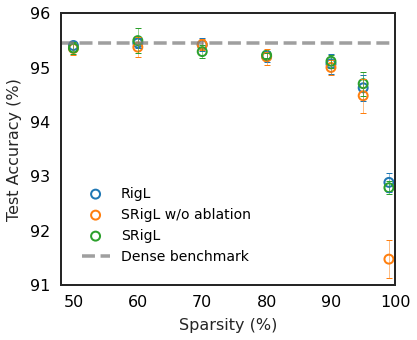

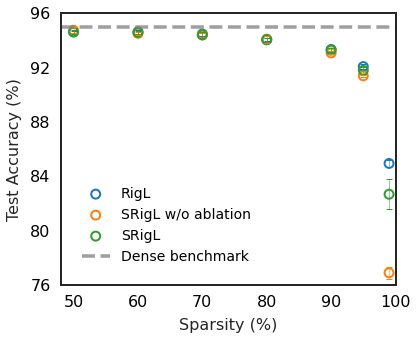

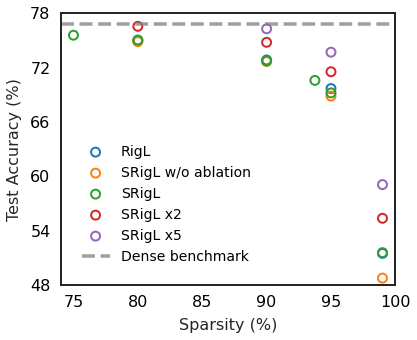

In [154]:

def get_accuracy_vs_sparsity_plot(model_name, ids, dense_benchmark_value, plot_99_sparsity=True, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = True, x_ticks = None, sparse_benchmarks=None):
    # _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy().sort_values(by="rigl.dense_allocation")
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    if not plot_99_sparsity:
        plot_df = plot_df.loc[plot_df["rigl.dense_allocation"] != 0.01]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    if sparse_benchmarks is not None:
        # these_colors = sns.color_palette("Set2")
        color = sns.color_palette("tab10").as_hex()[5]
        
        for idx, method in enumerate(sparse_benchmarks["method"].unique()):
            print(idx)
            df_slice = sparse_benchmarks.loc[(sparse_benchmarks["method"] == method)]
            # color=these_colors[idx]
            if _PLOT_FUNCT=='scatter':
                ax.scatter(
                    df_slice["sparsity"], df_slice["mean"], label=method, color=color, **_MEAN_MARKER
                )
            else:
                ax.plot(
                    df_slice["sparsity"], df_slice["mean"],  marker='x', color=color, alpha=0.9, label=method
                )   
                if plot_error_bars:
                    ax.fill_between(
                        df_slice["sparsity"],
                        df_slice["upper_bound"],
                        df_slice["lower_bound"],
                        color=color,
                        alpha=0.20
                    )


    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(plot_df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()):
        # print(epoch, fan_in, dynamic_ablation)   
        df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == fan_in) & (plot_df["rigl.dynamic_ablation"] == dynamic_ablation) & (plot_df["epoch"] == epoch)]            
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, plot_df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
        # display(agg_results)
        if _PLOT_FUNCT =="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
            # ax.scatter(
            #     df_slice["sparsity"], df_slice["best_accuracy"], marker='.', label=None, color=color, alpha=0.2,
            # )
            
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=color, alpha=0.9
            )
            ax.scatter(
                df_slice["sparsity"], df_slice["best_accuracy"], marker='.', color=color, alpha=0.5
            )
            if plot_error_bars:
                ax.fill_between(
                    agg_results["sparsity"],
                    agg_results["upper_bound"],
                    agg_results["lower_bound"],
                    color=color,
                    alpha=0.20
                )


    ax.plot(xlim, [dense_benchmark_value*100, dense_benchmark_value*100], "--",  label="Dense benchmark", color=_COLORS[-3], alpha=0.75)
    model_name_dict = dict(
        resnet18="ResNet18",
        wide_resnet22="WideResNet22"
    )
    plt.xlabel('Sparsity (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig_name = f"{model_name}_cifar_results"
    fig.savefig(f"../fig/{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

resnet18_params=dict(
    ids = resnet_ids,
    model_name ="../fig/resnet18",
    dense_benchmark_value = _RESNET18_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[91,96],
    xlim=[48,100]
)

wide_resnet22_params=dict(
    ids = wide_res_ids,
    model_name ="../fig/wide_resnet22",
    dense_benchmark_value = _WIDE_RESNET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[76,96],
    xlim=[48,100]
)

imagenet_params=dict(
    ids = imagenet.index.to_list(),
    model_name ="../fig/resnet50",
    dense_benchmark_value = _IMAGENET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[48,78],
    xlim=[74,100],
    plot_error_bars=True,
    sparse_benchmarks = structured_sparse_benchmarks
    # x_ticks=[80,90,95,99],
)

imagenet_params=dict(
    ids = imagenet.index.to_list(),
    model_name ="../fig/resnet50",
    dense_benchmark_value = _IMAGENET_BENCHMARK,
    plot_99_sparsity=True,
    ylim=[48,78],
    xlim=[74,100],
    plot_error_bars=True,
    sparse_benchmarks = None,
    # x_ticks=[80,90,95,99],
)

# _MEAN_MARKER=dict(s=80, facecolors='none', marker='o', alpha=1.0, linewidths=2)
# _SAMPLE_MARKER=dict(s=7.5, facecolors='full', marker='.', alpha=0.2)
# _PLOT_FUNCT="scatter"
fig = get_accuracy_vs_sparsity_plot(**resnet18_params)
fig = get_accuracy_vs_sparsity_plot(**wide_resnet22_params)
fig = get_accuracy_vs_sparsity_plot(**imagenet_params)
fig.show()


In [155]:
imagenet_x2.sort_values(by="best_accuracy", ascending=False)[_SUMMARY_COLS+["state"]]

,name,sweep_id,tags,best_accuracy,rigl.const_fan_in,rigl.dense_allocation,rigl.min_salient_weights_per_neuron,epoch,state
id,,,,,,,,,
23bqr8zs,resnet50_imagenet_dense_alloc-0.2_const_fan_in...,NaN,"['narval_cluster', 'x2-steps']",0.76530,True,0.20,0.3,205.0,finished
2umeh1wv,resnet50_imagenet_dense_alloc-0.1_const_fan_in...,NaN,"['narval_cluster', 'x2-steps']",0.74764,True,0.10,0.3,205.0,finished
uydgvx31,resnet50_imagenet_dense_alloc-0.05_const_fan_i...,NaN,"['narval_cluster', 'x2-steps']",0.71516,True,0.05,0.3,205.0,finished
26ypkzes,resnet50_imagenet_dense_alloc-0.01_const_fan_i...,NaN,"['narval_cluster', 'x2-steps']",0.55342,True,0.01,0.3,205.0,finished


In [156]:
structured_sparse_benchmarks

,method,sparsity,mean,upper_bound,lower_bound
0,SR-STE,75.00,76.2,76.2,76.2
1,SR-STE,93.75,71.5,71.5,71.5


In [157]:
imagenet_x5[["rigl.dense_allocation", "best_accuracy"]]

,rigl.dense_allocation,best_accuracy
id,,
lx23b1mp,0.10,0.76256
108mv65r,0.05,0.73676
jg7dix2z,0.01,0.59062


/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:44: RuntimeWarning: invalid value encountered in reduce
  return umr_minimum(a, axis, None, out, keepdims, initial, where)
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:40: RuntimeWarning: invalid value encountered in reduce
  return umr_maximum(a, axis, None, out, keepdims, initial, where)
/home/user/build/.venv/lib/python3.10/site-packages/scipy/stats/_distn_infrastructure.py:2162: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/home/user/build/.venv/lib/python3.10/site-packages/sci

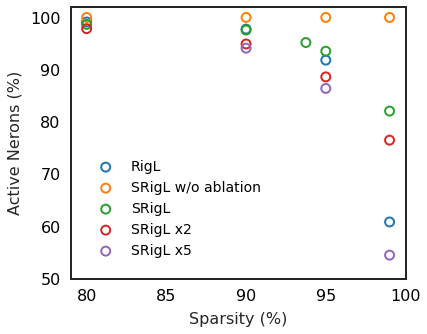

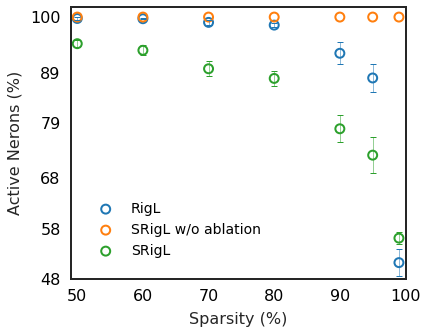

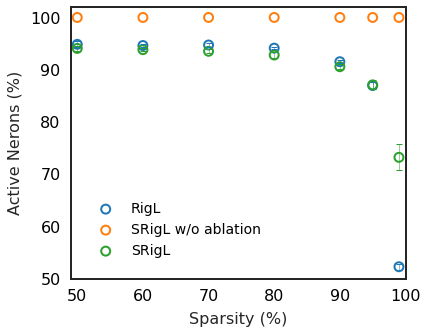

In [158]:
def plot_active_neurons_vs_sparsity(df, model_name="", ylim=[90,100], xlim=[49,100]):
    _TARGET_COL="_TOTAL_PERCENTAGE_ACTIVE_NEURONS"
    df=df.copy(deep=True)
    df = df.sort_values(by="rigl.dense_allocation")
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    plot_dfs = []
    fig, ax = plt.subplots(figsize=_FIG_SIZE)

    for idx, (epoch, fan_in, dynamic_ablation) in enumerate(df.groupby(["epoch", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=False).count().index.unique()): 
        df_slice = df.loc[(df["rigl.const_fan_in"] == fan_in) & (df["rigl.dynamic_ablation"] == dynamic_ablation) & (df["epoch"] == epoch)]    
        name, color = series_name_plot_mapper(fan_in, dynamic_ablation, df["epoch"].unique(), int(epoch))
        agg_results = get_confidence_bounds_df(df_slice, target_col=_TARGET_COL)
        # display(agg_results)
        if _PLOT_FUNCT=="scatter":
            ax.scatter(
                agg_results["sparsity"], agg_results["mean"], label=name, color=color, **_MEAN_MARKER
            )
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results["sparsity"], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results["sparsity"], agg_results["mean"], marker='x', label=name, color=color, alpha=0.9
            )
            ax.fill_between(
                agg_results["sparsity"],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            ax.scatter(
                df_slice["sparsity"], df_slice[_TARGET_COL], marker='o', color=color, alpha=0.5
            )

    plt.xlabel('Sparsity (%)')
    plt.ylabel('Active Nerons (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels)
    leg = ax.legend()
    leg.get_frame().set_linewidth(0.0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    tick_spaces=5
    y_tick_eps = (max(ylim)-2 - min(ylim))/tick_spaces
    y_ticks = [int(min(ylim)+y_tick_eps*x) for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    # ax.legend(bbox_to_anchor=.35,0.35)
    fig.savefig(f"../fig/{model_name}_perc_active.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_perc_active.pdf",format="pdf", bbox_inches="tight")
    return fig

# sweep_id_ablation_exp = "a2uywunn"
# df.loc[df["sweep_id"]==sweep_id_ablation_exp]["rigl.dense_allocation"].unique()

# resnet18_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="resnet18")].index.to_list()
# wide_resnet22_const_fan_false_ids=df.loc[(df["sweep_id"]==sweep_id_ablation_exp) & (df["model"]=="wide_resnet22")].index.to_list()
# imagenet_ids = imagenet.loc[imagenet["rigl.dynamic_ablation"] == True].index
# fig = plot_active_neurons_vs_sparsity(imagenet.loc[imagenet_ids], "imagenet", ylim=[58, 100], xlim=[0.79, 1.0])
# fig = plot_active_neurons_vs_sparsity(df.loc[new_high_sparse_ids+resnet18_const_fan_false_ids], "resnet18", ylim=[50, 100])
# fig = plot_active_neurons_vs_sparsity(df.loc[wide_const_fan_ids+wide_resnet22_const_fan_false_ids], "wide_resnet22", ylim=[50, 100])
fig = plot_active_neurons_vs_sparsity(imagenet, "imagenet", ylim=[50, 102], xlim=[79, 100])
fig = plot_active_neurons_vs_sparsity(df.loc[resnet_ids], "resnet18", ylim=[48, 102])
fig = plot_active_neurons_vs_sparsity(df.loc[wide_res_ids], "wide_resnet22", ylim=[50, 102])

# Min Salient

/tmp/ipykernel_64932/3765050075.py:76: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  min_sal_df["epoch"] = min_sal_df.loc[min_sal_df["epoch"]==249, 'epoch'] = 250


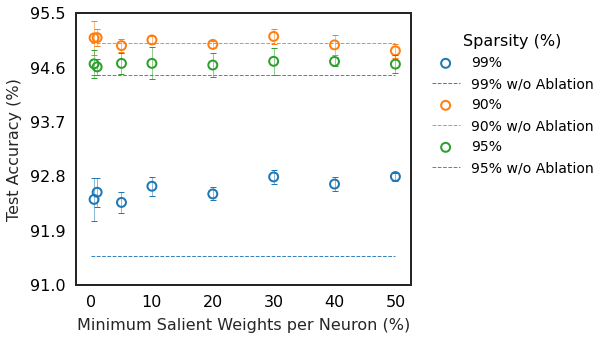

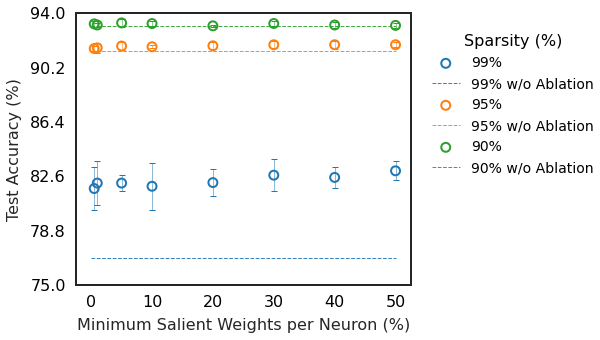

In [159]:
## Hyperparam search for min salient

def plot_min_salient_sweep(df, model_name="", ylim=[90,100], xlim=[49,100]):
    _TARGET_COL="best_accuracy"
    x_col = "rigl.min_salient_weights_per_neuron"
    df=df.copy(deep=True)
    df[_TARGET_COL] = df[_TARGET_COL]*100
    df[x_col] = df[x_col]*100
    df = df.sort_values(by=x_col)
    df["sparsity"] = (1-df["rigl.dense_allocation"])*100
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    epoch_values = sorted(df["epoch"].unique())
    # epoch_color_value_inc = {epoch: 2+i for i, epoch in enumerate(epoch_values)}
    color_inc = 0
    
    for sparsity in df["sparsity"].unique():
        if not sparsity > 80:
            continue
        for epoch in df["epoch"].unique():
            color = _COLORS[color_inc]
            color_inc+=1
        df_slice_ablation = df.loc[(df["sparsity"] == sparsity) & (df["epoch"] == epoch) & (df["rigl.dynamic_ablation"]==True)]
        df_slice_no_ablation = df.loc[(df["sparsity"] == sparsity) & (df["epoch"] == epoch) & (df["rigl.dynamic_ablation"]==False)]
        
        # Dynamic
        name = f"{sparsity:.0f}%"
        if len (epoch_values) >1:
            steps_multiplier = round(epoch / epoch_values[0])
            name = name + f" x{steps_multiplier}"
        agg_results = get_confidence_bounds_df(df_slice_ablation, target_col=_TARGET_COL, x_col=x_col)
        if _PLOT_FUNCT == "scatter":
            ax.scatter(agg_results[x_col], agg_results["mean"], label=name, color=color, **_MEAN_MARKER)
            yerr= [a["upper_bound"]-a["mean"] for _,a in agg_results.iterrows()]
            ax.errorbar(agg_results[x_col], agg_results["mean"], yerr=yerr,fmt="none", color=color, elinewidth=0.5, capsize=3)
        else:
            ax.plot(
                agg_results[x_col], agg_results["mean"], marker='x', label=name, color=color, alpha=1.0
            )
            ax.fill_between(
                agg_results[x_col],
                agg_results["upper_bound"],
                agg_results["lower_bound"],
                color=color,
                alpha=0.20
            )
            ax.scatter(
                df_slice_ablation[x_col], df_slice_ablation[_TARGET_COL], marker='o', color=color, alpha=0.5
            )
        benchmark_val = df_slice_no_ablation[_TARGET_COL].mean()
        ax.plot(xlim, [benchmark_val, benchmark_val], "--",  label=f"{sparsity:.0f}% w/o Ablation", color=color, alpha=0.9, linewidth=1)

    plt.xlabel('Minimum Salient Weights per Neuron (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="best", bbox_to_anchor=(1,1),framealpha=0)
    # ax.legend(bbox_to_anchor='upper right')
    # leg = ax.legend().get_frame()
    # leg.set_linewidth(0.0)
    
    
    ax.get_legend().set_title("Sparsity (%)")
    ax.set_ylim(ylim)
    # ax.set_xlim(xlim)
    # ax.set_xscale("log")
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    fig.savefig(f"../fig/{model_name}_salient_sweep.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_salient_sweep.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}_salient_sweep.pdf",format="pdf", bbox_inches="tight")
    return fig


min_sal_df = df.loc[df["tags"].str.contains("sweep_1fik36lx")]
min_sal_df["epoch"] = min_sal_df.loc[min_sal_df["epoch"]==249, 'epoch'] = 250
min_sal_df = pd.concat([min_sal_df, resnet18_no_ablation, wide_resnet22_no_ablation])
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="resnet18"], model_name="resnet18", ylim=[91,95.5], xlim=[0,50])
fig.show()
fig = plot_min_salient_sweep(min_sal_df.loc[min_sal_df["model"]=="wide_resnet22"], model_name="wide_resnet22",ylim=[75,94], xlim=[0,50])
fig.show()

In [160]:
'''
\begin{table}[tp]
\renewcommand{\arraystretch}{0.6}
\begin{center}
\caption{Test accuracy of ResNet-18 trained on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs}\label{table:resnet18_cifar10_table}
\begin{tabular}{@{}cccc@{}}
\toprule
& \gls{origl} & \multicolumn{2}{c}{\gls{srigl}} \\
\cmidrule(lr){3-4}
sparsity (\%) &  & w/o & w/ ablation \\
\midrule
50 & $95.40\pm 0.06$ & $95.35\pm 0.09$ & $95.36\pm 0.08$ \\\addlinespace
60 & $95.45\pm 0.08$ & $95.37\pm 0.15$ & $95.49\pm 0.19$ \\\addlinespace
70 & $95.41\pm 0.10$ & $95.42\pm 0.08$ & $95.29\pm 0.10$ \\\addlinespace
80 & $95.20\pm 0.08$ & $95.19\pm 0.12$ & $95.22\pm 0.04$ \\\addlinespace
90 & $95.06\pm 0.14$ & $95.00\pm 0.11$ & $95.11\pm 0.10$ \\\addlinespace
95 & $94.62\pm 0.20$ & $94.48\pm 0.25$ & $94.70\pm 0.18$ \\\addlinespace
99 & $92.88\pm 0.14$ & $91.47\pm 0.28$ & $92.79\pm 0.09$ \\
\midrule
0 & \multicolumn{3}{c}{\emph{ResNet-18~\citep{he_deep_2016}}:\quad $95.45$}\\
\bottomrule
\end{tabular}
\end{center}
\end{table}

'''

'\n\x08egin{table}[tp]\n\renewcommand{\x07rraystretch}{0.6}\n\x08egin{center}\n\\caption{Test accuracy of ResNet-18 trained on CIFAR-10. Mean and 95\\% confidence intervals are reported over five runs}\\label{table:resnet18_cifar10_table}\n\x08egin{tabular}{@{}cccc@{}}\n\toprule\n& \\gls{origl} & \\multicolumn{2}{c}{\\gls{srigl}} \\\n\\cmidrule(lr){3-4}\nsparsity (\\%) &  & w/o & w/ ablation \\\n\\midrule\n50 & $95.40\\pm 0.06$ & $95.35\\pm 0.09$ & $95.36\\pm 0.08$ \\\x07ddlinespace\n60 & $95.45\\pm 0.08$ & $95.37\\pm 0.15$ & $95.49\\pm 0.19$ \\\x07ddlinespace\n70 & $95.41\\pm 0.10$ & $95.42\\pm 0.08$ & $95.29\\pm 0.10$ \\\x07ddlinespace\n80 & $95.20\\pm 0.08$ & $95.19\\pm 0.12$ & $95.22\\pm 0.04$ \\\x07ddlinespace\n90 & $95.06\\pm 0.14$ & $95.00\\pm 0.11$ & $95.11\\pm 0.10$ \\\x07ddlinespace\n95 & $94.62\\pm 0.20$ & $94.48\\pm 0.25$ & $94.70\\pm 0.18$ \\\x07ddlinespace\n99 & $92.88\\pm 0.14$ & $91.47\\pm 0.28$ & $92.79\\pm 0.09$ \\\n\\midrule\n0 & \\multicolumn{3}{c}{\\emph{ResNet-18~

In [161]:
def get_results_table(df, ids, benchmark_value, caption, label, ) -> str:
    df = get_df_for_table(df, ids)
    df=df.copy(deep=True)
    table_str=""
    table_header=(
        "\\begin{table}[tp]\n"
        "\\renewcommand{\\arraystretch}{0.6}\n"
        "\\begin{center}\n"
        f"\\caption{{{caption}}}\\label{{table:{label}}}\n"
        "\\begin{tabular}{@{}cccc@{}}\n"
        "\\toprule\n"
        "& \\gls{origl} & \\multicolumn{2}{c}{\\gls{srigl}} \\\\ \n"
        "sparsity (\\%) &  & w/o & w/ ablation \\\\ \n"
        "\\midrule"
    )
    
    table_str+=table_header
    df = df.groupby(["rigl.dense_allocation", "rigl.const_fan_in", "rigl.dynamic_ablation"], dropna=True).agg(["mean", "std"])
    # display(df)
    df = df.sort_values(by=("sparsity", "mean"), ascending=True)


    for s in df["sparsity"]["mean"].unique():
        df_slice=df.loc[df["sparsity"]['mean']==s]
        row = get_table_row(df_slice, s)
        table_str+="\n"
        table_str+=row
    
    table_footer = (
        "\n\\midrule \n"
        "0 & \\multicolumn{3}{c}{\\emph{ResNet-18~\\citep{he_deep_2016}}:\\quad "
        f"${benchmark_value:.2f}$}}\\\\ \n"
        "\\bottomrule \n"
        "\\end{tabular} \n"
        "\\end{center} \n"
        "\end{table} \n"
    )
    
    table_str+=table_footer
    return table_str

def get_df_for_table(df, ids, fill_best_nan:bool=True,):
    interested_cols=[
        "rigl.const_fan_in",
        "rigl.dynamic_ablation",
        "rigl.dense_allocation",
        "accuracy",
        "best_accuracy",
        "sparsity"
    ]
    df["sparsity"] = 1-df["rigl.dense_allocation"]
    df_slice = df.loc[ids][interested_cols]
    df = df_slice.copy(deep=True)
    if fill_best_nan:
        df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
        # df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    df["+/-"] = df["best_accuracy"] - df["accuracy"]
    return df
def get_bold_text(mean_std_name):
    for idx, (mean, std, name) in enumerate(mean_std_name):
        if np.isnan(std):
            std=0
        others=list(range(len(mean_std_name)))
        others.pop(idx)
        bold_text = True
        for other in others:
            if mean - std < mean_std_name[other][0]+mean_std_name[other][1]:
                bold_text = False
        if bold_text:
            name = f"\\mathbf{{{name}}}"
            mean_std_name[idx][2] = name
    return mean_std_name

def get_table_row(df_slice, s):
    # Index is dense_alloc, const_fan, dynamic_ablation
    srigl_ablation_slice = df_slice.loc[:, True, True]
    srigl_ablation_mean=srigl_ablation_slice["best_accuracy"]["mean"].item()
    srigl_ablation_std=srigl_ablation_slice["best_accuracy"]["std"].item()
    srigl_ablation_text = f"{srigl_ablation_mean*100:.1f}"
    if not np.isnan(srigl_ablation_std):
        srigl_ablation_text += f"\\pm {srigl_ablation_std*100:.1f}"
    else:
        srigl_ablation_std=0
    vanilla_slice = df_slice.loc[:, False, :]
    vanilla_mean=vanilla_slice["best_accuracy"]["mean"].item()
    vanilla_std=vanilla_slice["best_accuracy"]["std"].item()
    vanilla_text = f"{vanilla_mean*100:.1f}"
    if not np.isnan(vanilla_std):
        vanilla_text += f"\\pm {vanilla_std*100:.1f}"
    else:
        vanilla_std=0
    no_ablation_slice = df_slice.loc[:, True, False]
    no_ablation_mean=no_ablation_slice["best_accuracy"]["mean"].item()
    no_ablation_std=no_ablation_slice["best_accuracy"]["std"].item()
    no_ablation_text = f"{no_ablation_mean*100:.1f}"
    if not np.isnan(no_ablation_std):
        no_ablation_text += f"\\pm {no_ablation_std*100:.1f}"
    else:
        no_ablation_text=no_ablation_text

    mean_std_name = [
        [vanilla_mean, vanilla_std, vanilla_text],
        [no_ablation_mean, no_ablation_std, no_ablation_text],
        [srigl_ablation_mean, srigl_ablation_std, srigl_ablation_text],
    ]
    mean_std_name = get_bold_text(mean_std_name)
    vanilla_text=mean_std_name[0][2]
    no_ablation_text=mean_std_name[1][2]
    srigl_ablation_text=mean_std_name[2][2]
    row_text = f"{s*100:.0f} & ${vanilla_text}$ & ${no_ablation_text}$ & ${srigl_ablation_text}$ \\\\ \\addlinespace"
    return row_text



resnet18_table_args = dict(
    df=df,
    ids=resnet_ids,
    benchmark_value=_RESNET18_BENCHMARK,
    caption= "Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs",
    label="resnet18_cifar10_table"
    
)

wide_resnet_table_args = dict(
    df=df,
    ids=wide_res_ids,
    benchmark_value=_WIDE_RESNET_BENCHMARK,
    caption= "Test accuracy of Wide ResNet-22 trained on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs",
    label="wide_resnet22_table"
    
)

imagenet_table_ids = pd.concat([imagenet_no_ablation, imagenet_x1, imagenet_og_rigl]).index
imagenet_table_args = dict(
    df=df,
    ids=imagenet_table_ids,
    benchmark_value=_IMAGENET_BENCHMARK,
    caption= "Test accuracy of ResNet-50 trained on ImageNet.",
    label="resnet50_imagenet_table"
    
)
for kwargs in [resnet18_table_args, wide_resnet_table_args, imagenet_table_args]:
    print(get_results_table(**kwargs))


\begin{table}[tp]
\renewcommand{\arraystretch}{0.6}
\begin{center}
\caption{Test accuracy of ResNet-18 trained with RigL on CIFAR-10. Mean and 95\% confidence intervals are reported over five runs}\label{table:resnet18_cifar10_table}
\begin{tabular}{@{}cccc@{}}
\toprule
& \gls{origl} & \multicolumn{2}{c}{\gls{srigl}} \\ 
sparsity (\%) &  & w/o & w/ ablation \\ 
\midrule
50 & $95.4\pm 0.1$ & $95.3\pm 0.1$ & $95.4\pm 0.1$ \\ \addlinespace
60 & $95.4\pm 0.1$ & $95.4\pm 0.2$ & $95.5\pm 0.2$ \\ \addlinespace
70 & $95.4\pm 0.1$ & $95.4\pm 0.1$ & $95.3\pm 0.1$ \\ \addlinespace
80 & $95.2\pm 0.1$ & $95.2\pm 0.1$ & $95.2\pm 0.0$ \\ \addlinespace
90 & $95.1\pm 0.1$ & $95.0\pm 0.1$ & $95.1\pm 0.1$ \\ \addlinespace
95 & $94.6\pm 0.2$ & $94.5\pm 0.3$ & $94.7\pm 0.2$ \\ \addlinespace
99 & $92.9\pm 0.1$ & $91.5\pm 0.3$ & $92.8\pm 0.1$ \\ \addlinespace
\midrule 
0 & \multicolumn{3}{c}{\emph{ResNet-18~\citep{he_deep_2016}}:\quad $0.95$}\\ 
\bottomrule 
\end{tabular} 
\end{center} 
\end{table} 

\begin{

/tmp/ipykernel_64932/4088922742.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
/tmp/ipykernel_64932/4088922742.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["best_accuracy"].loc[df["best_accuracy"].isna()] = df["accuracy"].loc[df["best_accuracy"].isna()]
/tmp/ipykernel_64932/4088922742.py:55: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-vie

[95.31999707221985, 93.00599694252014, 92.2599983215332]


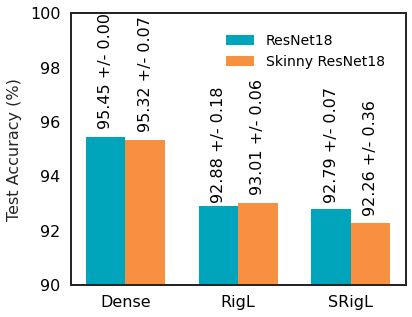

In [162]:
# Skinny ResNet


def skinny_resnet_plot(model_name, ids, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = True, x_ticks = None):
    # _BENCHMARK_VALUE = 0.9506

    plot_df = df.loc[ids].copy(deep=True)
    plot_df["rigl.dynamic_ablation"].fillna(False, inplace=True)
    plot_df = plot_df.loc[plot_df["state"] == "finished"]
    plot_df["sparsity"] = (1-plot_df["rigl.dense_allocation"])*100
    plot_df["sparsity"].fillna(-1, inplace=True)
    plot_df["best_accuracy"] = plot_df["best_accuracy"]*100
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    # Dense, RigL, SRigL, 
    wide_means =[]
    wide_pm =[]
    skinny_means = []
    skinny_pm = []
    df_slice = plot_df.loc[plot_df["sparsity"]== -1]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(dense_benchmark_value*100)
    wide_pm.append((0,0))
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
     # rigl
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == False) & (plot_df["sparsity"] != -1) & (plot_df["model"] != "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(agg_results["mean"].item())
    wide_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == False) & (plot_df["sparsity"] != -1) & (plot_df["model"] == "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    # const_fan
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == True) & (plot_df["sparsity"] != -1) & (plot_df["model"] != "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    wide_means.append(agg_results["mean"].item())
    wide_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    df_slice = plot_df.loc[(plot_df["rigl.const_fan_in"] == True) & (plot_df["sparsity"] != -1) & (plot_df["model"] == "skinny_resnet18")]
    agg_results = get_confidence_bounds_df(df_slice, target_col="best_accuracy")
    skinny_means.append(agg_results["mean"].item())
    skinny_pm.append((agg_results["mean"].item()-agg_results["lower_bound"].item(), agg_results["mean"].item()-agg_results["upper_bound"].item()))
    
    x=np.arange(3)
    labels = ["Dense", "RigL", "SRigL"]
    width=.35 
    resnet18_bar = ax.bar(
        x=x-width/2,
        height=wide_means,
        width=width,
        label="ResNet18",
        yerr=np.array(wide_pm).T
    )
    print(skinny_means)
    skinny_resnet18_bar = ax.bar(
        x=x+width/2,
        height=skinny_means,
        width=width,
        label="Skinny ResNet18"
    )
    
    ax.set_ylabel('Test Accuracy (%)')
    ax.set_xticks(x, labels)
    ax.legend()
    ax.bar_label(resnet18_bar, labels = [f"{mean:.2f} +/- {error[0]:.2f}" for mean, error in list(zip(wide_means, wide_pm))], padding=8, fmt="%G", rotation=90, label_type="edge")
    ax.bar_label(skinny_resnet18_bar, labels = [f"{mean:.2f} +/- {error[0]:.2f}" for mean, error in list(zip(skinny_means, skinny_pm))], padding=8, fmt="%G", rotation=90, label_type="edge")

    ax.legend(bbox_to_anchor=(1,1))
    ax.set_ylim(ylim)
    fig_name = f"skinny_resnet_results"
    fig.savefig(f"../fig/{model_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{model_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

params=dict(
    ids = skinny_resnet.index.to_list(),
    model_name ="../fig/skinny_resnet",
    dense_benchmark_value = _RESNET18_BENCHMARK,
    ylim=[90,100],
    # xlim=[89,100]
)

fig = skinny_resnet_plot(**params)
fig.show()


In [163]:
def get_srigl_imagenet_results(df):
    df = df.copy(deep=True)
    df["best_accuracy"] = df["best_accuracy"] * 100
    df["dense_allocation"] = df["rigl.dense_allocation"]
    results = []
    # for d in df["dense_allocation"].unique():
    df = get_confidence_bounds_df(df,target_col="best_accuracy", x_col="dense_allocation")
    return df  

srigl_imagenet_results = get_srigl_imagenet_results(imagenet_x1)

_SRIGL_PARAMS["method"] = ["SRigL" for _ in list(range(len(_SRIGL_PARAMS)))]
srigl_imagenet_results = srigl_imagenet_results.merge(right=_SRIGL_PARAMS, on="dense_allocation", how="inner")
_SR_STE_PARAMS["method"] = ["SR-STE" for _ in list(range(len(_SR_STE_PARAMS)))]
inference_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["flops"].item()
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()
_SR_STE_PARAMS["normalized_flops"] = _SR_STE_PARAMS["flops"]/inference_flops
_SR_STE_PARAMS["training_flops"] = training_flops*2/3
_SR_STE_PARAMS["normalized_training_flops"] = _SR_STE_PARAMS["training_flops"]/training_flops
params = pd.concat([srigl_imagenet_results,_SR_STE_PARAMS])
params

/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/user/build/.venv/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,2.098419e+18,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,2.098419e+18,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


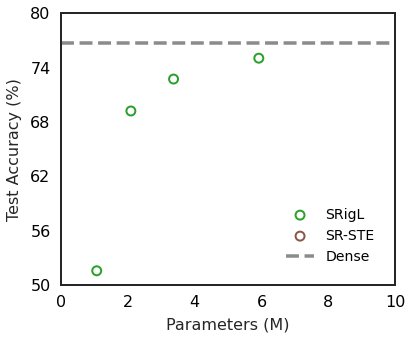

In [164]:
## Acc vs. Params:


# DF with columns: params, dense_params, mean, upper_bound, lower_bound, method

def get_accuracy_vs_params_plot(figure_name, plot_df, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None):
    
    plot_df = plot_df.copy(deep=True)
    if "params" not in plot_df:
        plot_df["params"] = plot_df["parameters"]
    plot_df["params"] = plot_df["params"]/1e6
    plot_df = plot_df.sort_values(by="params")
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice["params"], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    method="SR-STE"
    color = sns.color_palette("tab10").as_hex()[5]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice["params"], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
    plt.xlabel('Parameters (M)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right")
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

fig_params=dict(
    figure_name="acc-vs-param",
    plot_df=params,
    dense_benchmark_value=_IMAGENET_BENCHMARK,
    ylim=[50,80],
    xlim=[0,10],
)

fig = get_accuracy_vs_params_plot(**fig_params)
fig.show()


In [165]:
params

,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,2.098419e+18,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,2.098419e+18,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0            0.0500  69.183999          NaN          NaN         2.0   
1            0.1000  72.707999          NaN          NaN         4.0   
2            0.0100  51.547998          NaN          NaN         1.0   
3            0.2000  75.011998          NaN          NaN         5.0   
0            0.0625  71.500000         71.5         71.5         NaN   
1            0.2500  76.200000         76.2         76.2         NaN   

   rigl.dense_allocation      flops     model     params  normalized_flops  \
0                   0.05  12.270942  resnet50  2099700.0          0.122867   
1                   0.10  24.255628  resnet50  3374716.0          0.242868   
2                   0.01   2.562781  resnet50  1079578.0          0.025661   
3                   0.20  41.405995  resnet50  5920909.0          0.414592   
0                    NaN  10.731707       NaN        NaN          0.107455   
1                    NaN  2

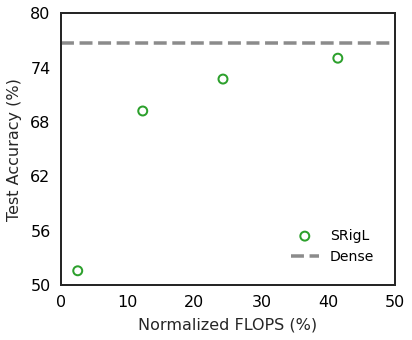

In [166]:
## Acc vs. Params:


# DF with columns: flops, dense_flops, mean, upper_bound, lower_bound, method

def get_accuracy_vs_flops_plot(figure_name, plot_df, dense_benchmark_value, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None):
    # plot_df = plot_df.loc[plot_df["method"].isin(include_methods)]
    plot_df = plot_df.copy(deep=True)
    if "flops" not in plot_df:
        plot_df["flops"] = plot_df["parameters"]
    plot_df["flops"] = plot_df["flops"]/dense_flops*100
    print(plot_df)
    plot_df = plot_df.sort_values(by="flops")
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice["flops"], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    # method="SR-STE"
    # color = sns.color_palette("tab10").as_hex()[5]
    # df_slice = plot_df.loc[plot_df["method"]==method]
    # ax.scatter(df_slice["flops"], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
    plt.xlabel('Normalized FLOPS (%)')
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right", framealpha=0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

# dense_flops = 8.189482496e9
dense_flops=8.2e9

fig_params=dict(
    figure_name="acc-vs-flops",
    plot_df=params,
    dense_benchmark_value=dense_flops,
    ylim=[50,80],
    xlim=[0,50],
)

fig = get_accuracy_vs_flops_plot(**fig_params)
fig.show()


In [167]:
display(params)

,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,2.098419e+18,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,2.098419e+18,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0            0.0500  69.183999          NaN          NaN         2.0   
1            0.1000  72.707999          NaN          NaN         4.0   
2            0.0100  51.547998          NaN          NaN         1.0   
3            0.2000  75.011998          NaN          NaN         5.0   
0            0.0625  71.500000         71.5         71.5         NaN   
1            0.2500  76.200000         76.2         76.2         NaN   

   rigl.dense_allocation         flops     model     params  normalized_flops  \
0                   0.05  1.006217e+09  resnet50  2099700.0         12.286701   
1                   0.10  1.988961e+09  resnet50  3374716.0         24.286779   
2                   0.01  2.101481e+08  resnet50  1079578.0          2.566073   
3                   0.20  3.395292e+09  resnet50  5920909.0         41.459172   
0                    NaN  8.800000e+08       NaN        NaN         10.745490   
1        

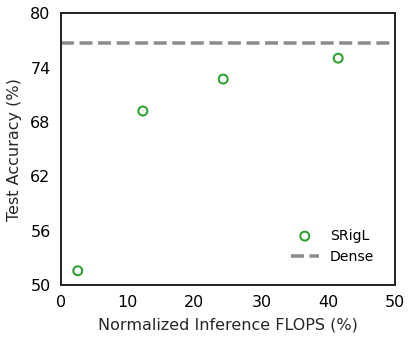

In [168]:
## Acc vs. Params:


# DF with columns: flops, dense_flops, mean, upper_bound, lower_bound, method

def get_accuracy_vs_normalized_flops_plot(x_col, figure_name, plot_df, dense_benchmark_value,x_axis_label, ylim=[0.9,1.0], xlim=[0.49,1.0], plot_error_bars: bool = False, x_ticks = None, ):
    
    plot_df = plot_df.copy(deep=True)
    plot_df[x_col] = plot_df[x_col]*100
    print(plot_df)
    plot_df = plot_df.sort_values(by=x_col)
    fig, ax = plt.subplots(figsize=_FIG_SIZE)
    
    method="SRigL"
    color=_COLORS[2]
    df_slice = plot_df.loc[plot_df["method"]==method]
    ax.scatter(df_slice[x_col], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)
    
    # method="SR-STE"
    # color = sns.color_palette("tab10").as_hex()[5]
    # df_slice = plot_df.loc[plot_df["method"]==method]
    # ax.scatter(df_slice[x_col], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

    ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
    plt.xlabel(x_axis_label)
    plt.ylabel('Test Accuracy (%)')
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles, labels, loc="lower right", framealpha=0)
    ax.set_ylim(ylim)
    ax.set_xlim(xlim)
    
    tick_spaces=5
    y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
    y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
    ax.set_yticks(y_ticks)
    if x_ticks is not None:
        ax.set_xticks(x_ticks)
    # ax.set_yscale("log")
    fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
    fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")
    return fig

# dense_flops = 8.189482496e9
# dense_flops=8.2e9
inference_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["flops"].item()
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()


fig_params=dict(
    x_col="normalized_flops",
    figure_name="acc-vs-normalized-inference-flops",
    plot_df=params,
    dense_benchmark_value=inference_flops,
    ylim=[50,80],
    xlim=[0,50], 
    x_axis_label=f"Normalized Inference FLOPS (%)"
)

fig = get_accuracy_vs_normalized_flops_plot(**fig_params)
fig.show()


   dense_allocation       mean  lower_bound  upper_bound  Unnamed: 0  \
0              0.05  69.183999          NaN          NaN         2.0   
1              0.10  72.707999          NaN          NaN         4.0   
2              0.01  51.547998          NaN          NaN         1.0   
3              0.20  75.011998          NaN          NaN         5.0   

   rigl.dense_allocation         flops     model     params  normalized_flops  \
0                   0.05  1.006217e+09  resnet50  2099700.0          0.122867   
1                   0.10  1.988961e+09  resnet50  3374716.0          0.242868   
2                   0.01  2.101481e+08  resnet50  1079578.0          0.025661   
3                   0.20  3.395292e+09  resnet50  5920909.0          0.414592   

   training_flops  normalized_training_flops method  parameters  dense_params  \
0    3.984043e+17                  12.657285  SRigL         NaN           NaN   
1    7.773687e+17                  24.696966  SRigL         NaN        

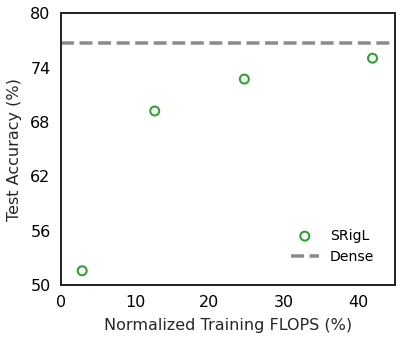

In [169]:
training_flops = _SRIGL_PARAMS.loc[_SRIGL_PARAMS["dense_allocation"].isna()]["training_flops"].item()
srigl_params_only = params.loc[params["method"]=="SRigL"]

fig_params=dict(
    x_col="normalized_training_flops",
    figure_name="acc-vs-normalized-training-flops",
    plot_df=srigl_params_only,
    dense_benchmark_value=training_flops,
    ylim=[50,80],
    xlim=[0,45],
    x_axis_label=f"Normalized Training FLOPS (%)"
)

fig = get_accuracy_vs_normalized_flops_plot(**fig_params)
fig.show()

In [170]:
params

,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,2.098419e+18,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,2.098419e+18,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


In [171]:
4.400000e+08/dense_flops

0.05365853658536585

In [172]:
4.975516e+08/dense_flops

0.0606770243902439

In [173]:
params

,dense_allocation,mean,lower_bound,upper_bound,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,method,parameters,dense_params,macs
0,0.0500,69.183999,NaN,NaN,2.0,0.05,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,SRigL,NaN,NaN,NaN
1,0.1000,72.707999,NaN,NaN,4.0,0.10,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,SRigL,NaN,NaN,NaN
2,0.0100,51.547998,NaN,NaN,1.0,0.01,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,SRigL,NaN,NaN,NaN
3,0.2000,75.011998,NaN,NaN,5.0,0.20,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,SRigL,NaN,NaN,NaN
0,0.0625,71.500000,71.5,71.5,NaN,NaN,8.800000e+08,NaN,NaN,0.107455,2.098419e+18,0.666667,SR-STE,3520000.0,25557032.0,4.400000e+08
1,0.2500,76.200000,76.2,76.2,NaN,NaN,2.340000e+09,NaN,NaN,0.285732,2.098419e+18,0.666667,SR-STE,7930000.0,25557032.0,1.170000e+09


In [174]:
params[["dense_allocation", "training_flops", "flops","method"]]


,dense_allocation,training_flops,flops,method
0,0.0500,3.984043e+17,1.006217e+09,SRigL
1,0.1000,7.773687e+17,1.988961e+09,SRigL
2,0.0100,9.142521e+16,2.101481e+08,SRigL
3,0.2000,1.319676e+18,3.395292e+09,SRigL
0,0.0625,2.098419e+18,8.800000e+08,SR-STE
1,0.2500,2.098419e+18,2.340000e+09,SR-STE


In [175]:
_SRIGL_PARAMS

,Unnamed: 0,rigl.dense_allocation,flops,model,params,normalized_flops,training_flops,normalized_training_flops,dense_allocation,method
0,0,NaN,8.189482e+09,resnet50,25530472.0,1.000000,3.147628e+18,1.000000,NaN,SRigL
1,1,0.0100,2.101481e+08,resnet50,1079578.0,0.025661,9.142521e+16,0.029046,0.0100,SRigL
2,2,0.0500,1.006217e+09,resnet50,2099700.0,0.122867,3.984043e+17,0.126573,0.0500,SRigL
3,3,0.0625,1.254965e+09,resnet50,2418458.0,0.153241,4.943262e+17,0.157047,0.0625,SRigL
4,4,0.1000,1.988961e+09,resnet50,3374716.0,0.242868,7.773687e+17,0.246970,0.1000,SRigL
5,5,0.2000,3.395292e+09,resnet50,5920909.0,0.414592,1.319676e+18,0.419260,0.2000,SRigL
6,6,0.2500,3.903734e+09,resnet50,7181400.0,0.476677,1.515741e+18,0.481550,0.2500,SRigL


In [176]:
params = params.sort_values(by="rigl.dense_allocation", ascending=False)
params["sparsity"] = (1-params["rigl.dense_allocation"])*100
for idx, row in params.iterrows():
    print(f"{row['sparsity']}")
    print(f"{row['method']}")
    print(f"${row['training_flops']/1e9:.2f}$")
    print(f"${row['flops']/1e9:.2f}$")

80.0
SRigL
$1319675755.94$
$3.40$
90.0
SRigL
$777368722.28$
$1.99$
95.0
SRigL
$398404285.32$
$1.01$
99.0
SRigL
$91425210.03$
$0.21$
nan
SR-STE
$2098418944.19$
$0.88$
nan
SR-STE
$2098418944.19$
$2.34$


In [177]:
import plotly.express as px


imagenet_x2.index.to_list()

['26ypkzes', 'uydgvx31', '2umeh1wv', '23bqr8zs']

In [178]:
imagenet_x1

,ITOP Rate,Learning Rate,Training Loss,Unnamed: 0,_PRUNING_RATE,_TOTAL_ACTIVE_NEURONS,_TOTAL_PERCENTAGE_ACTIVE_NEURONS,_runtime,_step,_timestamp,...,z-module.layer4.2.conv3-Max-Grad-Per-Filter.values,z-module.layer4.2.conv3-Max-Inactive_Grad,z-module.layer4.2.conv3-Max-Inactive_Weight,z-module.layer4.2.conv3-Max-Weight-Per-Filter._type,z-module.layer4.2.conv3-Max-Weight-Per-Filter.bins,z-module.layer4.2.conv3-Max-Weight-Per-Filter.values,z-module.layer4.2.conv3-Weight-Dist._type,z-module.layer4.2.conv3-Weight-Dist.bins,z-module.layer4.2.conv3-Weight-Dist.values,z-module.layer4.2.conv3_total-active-neurons
id,,,,,,,,,,,,,,,,,,,,,
1oid9nmo,0.508198,0.0002,2.313556,198,0.000013,25782.0,93.548621,214098.0,256001.0,1.673984e+09,...,"[358, 6, 9, 10, 16, 22, 34, 32, 42, 50, 78, 82...",0.000059,0.0,histogram,"[0, 0.007086341269314289, 0.014172682538628578...","[357, 0, 0, 7, 7, 10, 30, 35, 35, 35, 48, 61, ...",histogram,"[-0.16545777022838593, -0.1557861566543579, -0...","[1, 2, 2, 2, 5, 17, 27, 74, 125, 317, 701, 146...",1691.0
14so3lij,0.681067,0.0002,2.123610,199,0.000013,26896.0,97.590711,214220.0,256001.0,1.673984e+09,...,"[106, 0, 7, 6, 8, 25, 25, 35, 57, 77, 111, 108...",0.000002,0.0,histogram,"[0, 0.007974066771566868, 0.015948133543133736...","[106, 0, 1, 7, 13, 19, 36, 46, 84, 106, 127, 1...",histogram,"[-0.2143898457288742, -0.2030659317970276, -0....","[1, 0, 0, 0, 0, 1, 0, 1, 2, 12, 19, 111, 330, ...",1942.0
2brxovy4,0.173606,0.0002,3.215526,200,0.000013,22623.0,82.086357,229192.0,256001.0,1.673999e+09,...,"[936, 15, 25, 28, 38, 37, 56, 41, 63, 42, 46, ...",0.000005,0.0,histogram,"[0, 0.0073420885019004345, 0.01468417700380086...","[899, 9, 22, 12, 8, 16, 15, 18, 21, 27, 34, 33...",histogram,"[-0.3252486288547516, -0.3128245174884796, -0....","[1, 0, 1, 1, 1, 0, 1, 1, 2, 5, 6, 0, 5, 9, 16,...",1151.0
4zbwd4nt,0.837478,0.0002,2.015849,201,0.000013,27193.0,98.668360,214790.0,256001.0,1.673984e+09,...,"[19, 0, 0, 3, 2, 3, 8, 8, 18, 16, 45, 59, 64, ...",0.000008,0.0,histogram,"[0, 0.009433654136955738, 0.018867308273911476...","[19, 0, 1, 11, 24, 47, 97, 166, 220, 197, 235,...",histogram,"[-0.17330968379974365, -0.16116806864738464, -...","[1, 0, 0, 0, 0, 2, 9, 63, 214, 1099, 4974, 190...",2029.0


In [179]:
# min sal per layer
min_sal_per_layer = pd.DataFrame(
    {'rigl.dense_allocation': {0: 0.01,
  1: 0.01,
  2: 0.01,
  3: 0.01,
  4: 0.01,
  5: 0.01,
  6: 0.01,
  7: 0.01,
  8: 0.01,
  9: 0.01,
  10: 0.01,
  11: 0.01,
  12: 0.01,
  13: 0.01,
  14: 0.01,
  15: 0.01,
  16: 0.01,
  17: 0.01,
  18: 0.01,
  19: 0.01,
  20: 0.01,
  21: 0.01,
  22: 0.01,
  23: 0.01,
  24: 0.01,
  25: 0.01,
  26: 0.01,
  27: 0.01,
  28: 0.01,
  29: 0.01,
  30: 0.01,
  31: 0.01,
  32: 0.01,
  33: 0.01,
  34: 0.01,
  35: 0.01,
  36: 0.01,
  37: 0.01,
  38: 0.01,
  39: 0.01,
  40: 0.01,
  41: 0.01,
  42: 0.01,
  43: 0.01,
  44: 0.01,
  45: 0.01,
  46: 0.01,
  47: 0.01,
  48: 0.01,
  49: 0.01,
  50: 0.01,
  51: 0.01,
  52: 0.01},
 'min_sal_per_layer': {0: 1,
  1: 2,
  2: 3,
  3: 1,
  4: 1,
  5: 7,
  6: 3,
  7: 1,
  8: 7,
  9: 3,
  10: 1,
  11: 4,
  12: 2,
  13: 1,
  14: 2,
  15: 7,
  16: 2,
  17: 1,
  18: 7,
  19: 2,
  20: 1,
  21: 7,
  22: 2,
  23: 1,
  24: 4,
  25: 2,
  26: 1,
  27: 2,
  28: 7,
  29: 2,
  30: 1,
  31: 7,
  32: 2,
  33: 1,
  34: 7,
  35: 2,
  36: 1,
  37: 7,
  38: 2,
  39: 1,
  40: 7,
  41: 2,
  42: 1,
  43: 4,
  44: 2,
  45: 1,
  46: 2,
  47: 7,
  48: 2,
  49: 1,
  50: 7,
  51: 2,
  52: 1},
 'layer_name': {0: 'conv1',
  1: 'layer1.0.conv1',
  2: 'layer1.0.conv2',
  3: 'layer1.0.conv3',
  4: 'layer1.0.downsample.0',
  5: 'layer1.1.conv1',
  6: 'layer1.1.conv2',
  7: 'layer1.1.conv3',
  8: 'layer1.2.conv1',
  9: 'layer1.2.conv2',
  10: 'layer1.2.conv3',
  11: 'layer2.0.conv1',
  12: 'layer2.0.conv2',
  13: 'layer2.0.conv3',
  14: 'layer2.0.downsample.0',
  15: 'layer2.1.conv1',
  16: 'layer2.1.conv2',
  17: 'layer2.1.conv3',
  18: 'layer2.2.conv1',
  19: 'layer2.2.conv2',
  20: 'layer2.2.conv3',
  21: 'layer2.3.conv1',
  22: 'layer2.3.conv2',
  23: 'layer2.3.conv3',
  24: 'layer3.0.conv1',
  25: 'layer3.0.conv2',
  26: 'layer3.0.conv3',
  27: 'layer3.0.downsample.0',
  28: 'layer3.1.conv1',
  29: 'layer3.1.conv2',
  30: 'layer3.1.conv3',
  31: 'layer3.2.conv1',
  32: 'layer3.2.conv2',
  33: 'layer3.2.conv3',
  34: 'layer3.3.conv1',
  35: 'layer3.3.conv2',
  36: 'layer3.3.conv3',
  37: 'layer3.4.conv1',
  38: 'layer3.4.conv2',
  39: 'layer3.4.conv3',
  40: 'layer3.5.conv1',
  41: 'layer3.5.conv2',
  42: 'layer3.5.conv3',
  43: 'layer4.0.conv1',
  44: 'layer4.0.conv2',
  45: 'layer4.0.conv3',
  46: 'layer4.0.downsample.0',
  47: 'layer4.1.conv1',
  48: 'layer4.1.conv2',
  49: 'layer4.1.conv3',
  50: 'layer4.2.conv1',
  51: 'layer4.2.conv2',
  52: 'layer4.2.conv3'}}
)

In [180]:
min_sal_per_layer.head()

,rigl.dense_allocation,min_sal_per_layer,layer_name
0,0.01,1,conv1
1,0.01,2,layer1.0.conv1
2,0.01,3,layer1.0.conv2
3,0.01,1,layer1.0.conv3
4,0.01,1,layer1.0.downsample.0


In [181]:
min_sal_per_layer.layer_name.unique()

array(['conv1', 'layer1.0.conv1', 'layer1.0.conv2', 'layer1.0.conv3',
       'layer1.0.downsample.0', 'layer1.1.conv1', 'layer1.1.conv2',
       'layer1.1.conv3', 'layer1.2.conv1', 'layer1.2.conv2',
       'layer1.2.conv3', 'layer2.0.conv1', 'layer2.0.conv2',
       'layer2.0.conv3', 'layer2.0.downsample.0', 'layer2.1.conv1',
       'layer2.1.conv2', 'layer2.1.conv3', 'layer2.2.conv1',
       'layer2.2.conv2', 'layer2.2.conv3', 'layer2.3.conv1',
       'layer2.3.conv2', 'layer2.3.conv3', 'layer3.0.conv1',
       'layer3.0.conv2', 'layer3.0.conv3', 'layer3.0.downsample.0',
       'layer3.1.conv1', 'layer3.1.conv2', 'layer3.1.conv3',
       'layer3.2.conv1', 'layer3.2.conv2', 'layer3.2.conv3',
       'layer3.3.conv1', 'layer3.3.conv2', 'layer3.3.conv3',
       'layer3.4.conv1', 'layer3.4.conv2', 'layer3.4.conv3',
       'layer3.5.conv1', 'layer3.5.conv2', 'layer3.5.conv3',
       'layer4.0.conv1', 'layer4.0.conv2', 'layer4.0.conv3',
       'layer4.0.downsample.0', 'layer4.1.conv1', 'laye

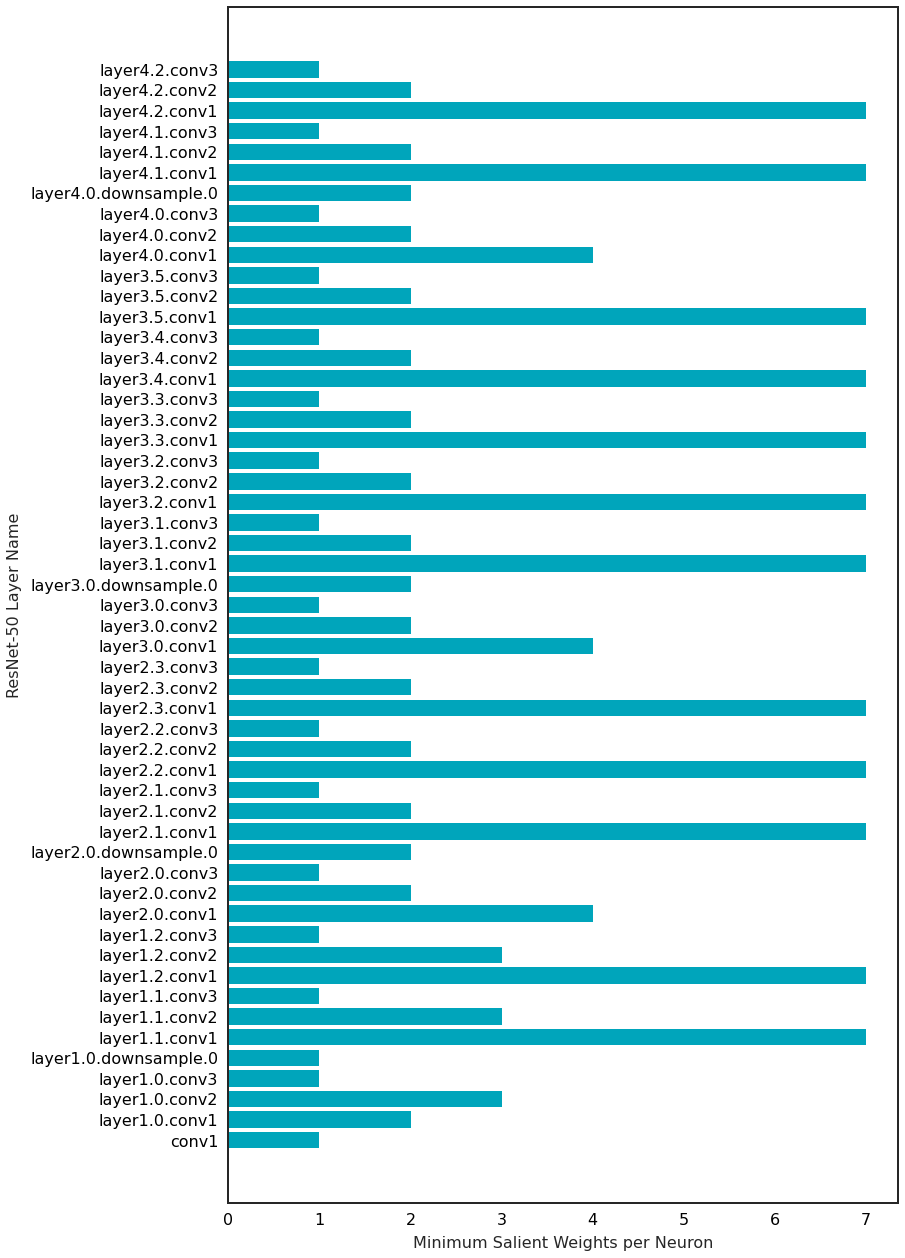

In [182]:
fig, ax = plt.subplots(figsize=(12,22))
plot_df = min_sal_per_layer
ax.barh(plot_df["layer_name"], plot_df["min_sal_per_layer"])
plt.xlabel("Minimum Salient Weights per Neuron")
plt.ylabel('ResNet-50 Layer Name')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="lower right", framealpha=0)
figure_name = "layer-vs-min-sal"
# ax.set_yscale("log")
fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")


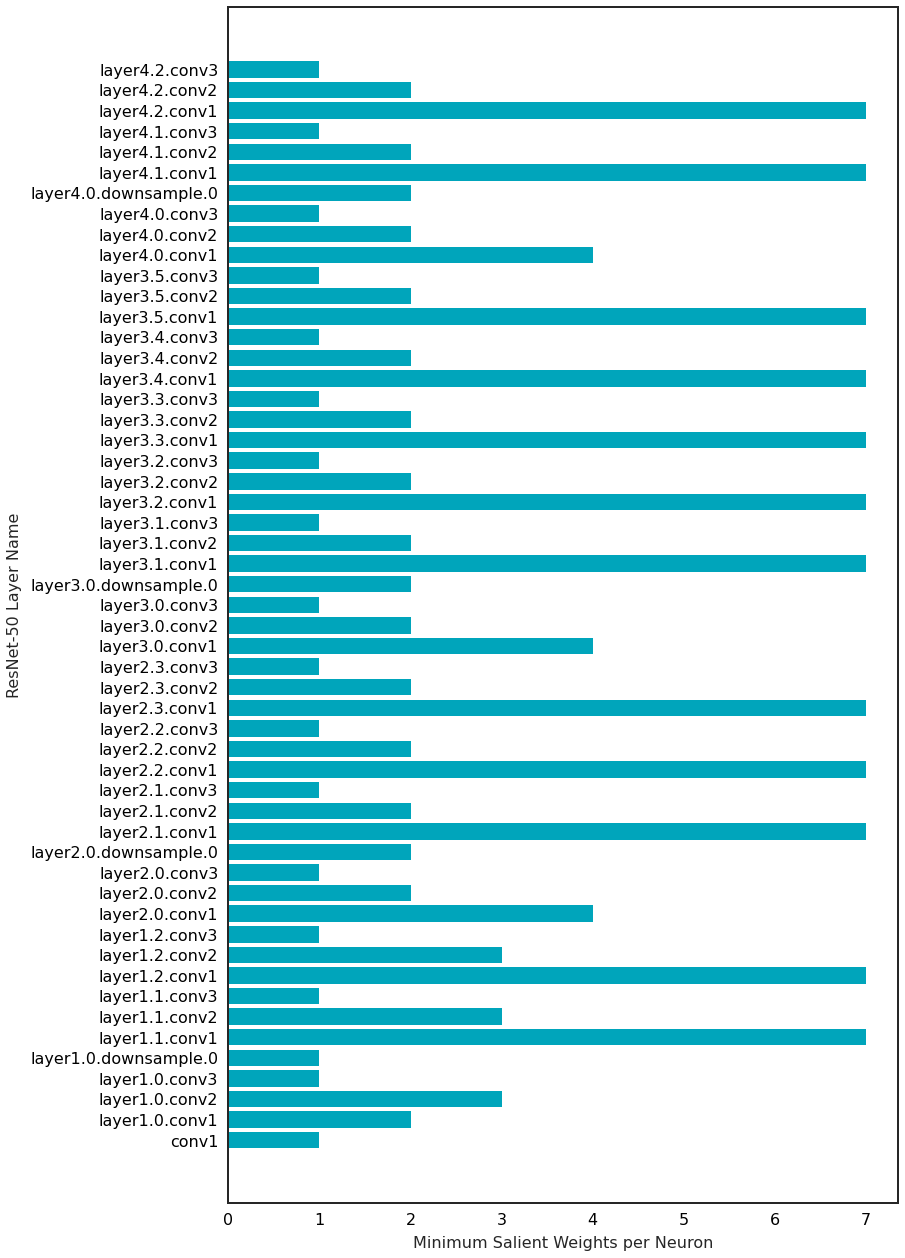

In [183]:
fig

In [184]:

    
method="SRigL"
color=_COLORS[2]
df_slice = plot_df.loc[plot_df["method"]==method]
ax.scatter(df_slice[x_col], df_slice['mean'], color=color,label=method, **_MEAN_MARKER)

# method="SR-STE"
# color = sns.color_palette("tab10").as_hex()[5]
# df_slice = plot_df.loc[plot_df["method"]==method]
# ax.scatter(df_slice[x_col], df_slice['mean'],color=color, label=method, **_MEAN_MARKER)

ax.plot(xlim, [_IMAGENET_BENCHMARK*100,_IMAGENET_BENCHMARK*100], "--",  label="Dense", color=_COLORS[-3], alpha=0.9)
plt.xlabel(x_axis_label)
plt.ylabel('Test Accuracy (%)')
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, loc="lower right", framealpha=0)
ax.set_ylim(ylim)
ax.set_xlim(xlim)

tick_spaces=5
y_tick_eps = (max(ylim) - min(ylim))/tick_spaces
y_ticks = [min(ylim)+y_tick_eps*x for x in range(tick_spaces+1)]
ax.set_yticks(y_ticks)
if x_ticks is not None:
    ax.set_xticks(x_ticks)
# ax.set_yscale("log")
fig.savefig(f"../fig/{figure_name}.png", dpi=600, bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.svg",format="svg", bbox_inches="tight")
fig.savefig(f"../fig/{figure_name}.pdf",format="pdf", bbox_inches="tight")



fig_params=dict(
    x_col="normalized_flops",
    figure_name="acc-vs-normalized-inference-flops",
    plot_df=params,
    dense_benchmark_value=inference_flops,
    ylim=[50,80],
    xlim=[0,50], 
    x_axis_label=f"Normalized Inference FLOPS (%)"
)


KeyError: 'method'